# A passenger logbook

Author: Frédéric DITH  |  Creation date: 2023-11-06  |  Last updated: 2023-11-07

`python`, `pandas`,`plotly-express`,`dash`


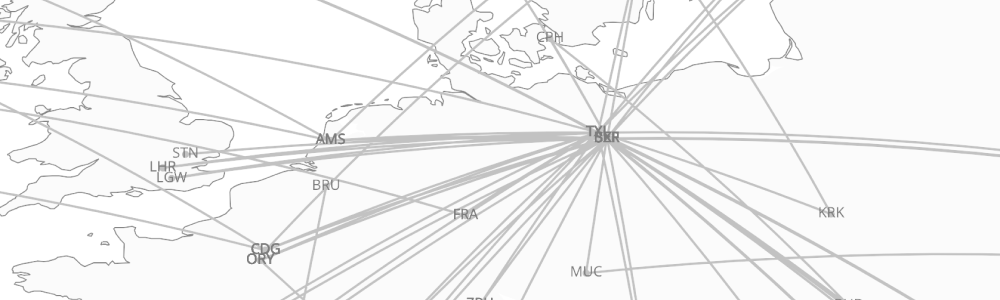

## Context

A [pilot logbook](https://en.wikipedia.org/wiki/Pilot_logbook) is a record of a pilot's flying hours. It contains every flight a pilot has flown, including flight time, number of landings, and types of instrument and approaches made. I'm not a pilot but I happen to have a spreadsheet I can use to create something similar, with a little bit of interactivity.

The idea behind this project is basically to transform this spreadsheet into a dashboard, and put my skills into practice.

## Result
You can see the dashboard [here](url), or at the very end of this notebook.

## Description

At the very basic level, this app:
- **Extracts the data**: it takes a .csv or .xls file as a raw input, and transforms it into a dataframe. This raw file should be structured so that each row stores one flight. It can contain many fields, but the four columns needed to make the dashboard work are:
    - a travel date
    - the 3-letter airport codes of origin and destination (following the [IATA standard](https://www.iata.org/en/publications/directories/code-search/), in separate columns)
    - the airline name
- **Transforms the data**:
    - calculate distances between each airports: with the help of a separate 'airports' dataframe, we add the distance for each flight to the file, based on the airport coordinates for each flight
    - calculate the CO2 emissions equivalent: with the help of the [climatiq.io API](https://www.climatiq.io/), we add the CO2 emissions equivalent to each flight.
- **Loads the data**
    - We create a sub-dataframe that we will use for the creation of the dashboard, only keeping the columns we will need. All calculations that are displayed in the dashboard are made from this sub-dataframe
    - (At this stage we also make a backup of the final file to a .csv, for archiving purpose)
- **Generates a dashboard**:
    - [Dash](https://dash.plotly.com/) and [Plotly Express](https://plotly.com/python/plotly-express/) are used to generate this dashboard
    - The dashboard contains two tabs:
      - All time statistics: shows the statistics for all the flights in the file
      - Yearly statistics: shows the data only for the selected year

## Sources and references

| Data              | Description                                                                                                                                                                                                                                                                               |   |
|:-------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|
| **CO2 emissions** | We use the [climatiq.io REST API](https://www.climatiq.io/)  to calculate the CO2 emissions equivalents for each of the flights we have in our file. This API takes a distance and returns a CO2e value for this distance.                                                                |   |
| **Airports**      | [Airport codes on github](https://github.com/datasets/airport-codes/blob/master/data/airport-codes.csv) Note: TXL and SXF are present in this file but without the IATA code, due to the fact that they're now closed. These two codes were therefore added manually.                                   |   |
| **Flights data**  | I happen to maintain a very old spreadsheet, where I write down every single flight I boarded since 2014. This file is imperfect (I am missing quite a lot of information, especially for the older flights), this partly explains why some flights are not displayed properly in the dashboard. |   |


In [598]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

# necessary for climatiq API call
import requests
import json

# haversine: calculates the great-circle distance between two points on earth
from haversine import haversine

# dash modules for dashboard
!pip install dash
import dash
from dash import Dash, dcc, html, Input, Output, dash_table

# -------- storage, not used --------
# import csv - transforms .txt to .csv


# 1 Airport dataframe

In [599]:
# source https://github.com/datasets/airport-codes/blob/master/data/airport-codes.csv
airports = pd.read_csv("./data/airport-codes.csv")

# only keep relevant columns
keep = ['iata_code','name','coordinates']
airports = airports[keep]
airports[['lat', 'lon']] = airports['coordinates'].str.split(',', expand=True)
airports = airports.drop(columns=['coordinates']) # drop merged coord
airports = airports.dropna(subset=['iata_code']) # drop airports with no iata code
airports = airports.rename(columns={'iata_code': 'iata'})

# convert coord to floats
airports['lat'] = airports['lat'].astype(float)
airports['lon'] = airports['lon'].astype(float)

#airports.columns

# 2 Import data

In [326]:
log = pd.read_csv("./data/flights_log.csv")
keep = ['segment_id','trip_id','year_travel','date_purchase','date_travel','booking_code','airport_d','airport_a','city_d','city_a','airline','flight_number','price_paid_eur','purpose']
log = log[keep]

# 3 Transform

### 3.1 Add flight distances

In [327]:
# 1 Calculates the distances of each flight
def calculate_flight_distance(row):
    origin = (airports.loc[airports['iata'] == row['airport_d'], 'lat'].values,
              airports.loc[airports['iata'] == row['airport_d'], 'lon'].values)
    destination = (airports.loc[airports['iata'] == row['airport_a'], 'lat'].values,
                   airports.loc[airports['iata'] == row['airport_a'], 'lon'].values)
    if len(origin[0]) == 0 or len(destination[0]) == 0:
        return None  # Skip rows with missing or invalid airport codes
    distance = haversine((origin[0][0], origin[1][0]), (destination[0][0], destination[1][0]))
    return distance

log['distance_km'] = log.apply(calculate_flight_distance, axis=1)

# 2 Adds the origin and dest to the df, and creates a df called combined
origin_coords = log.merge(airports, left_on='airport_d', right_on='iata', how='left')
combined = origin_coords.merge(airports, left_on='airport_a', right_on='iata', how='left')
combined = combined.rename(columns={'lat_x': 'lat_origin', 'lon_x': 'lon_origin', 'lat_y': 'lat_arrival', 'lon_y': 'lon_arrival'})

# 3 is optional - capitalize strings
combined['airline'] = combined['airline'].str.title()
combined['city_d'] = combined['city_d'].str.title()
combined['city_a'] = combined['city_a'].str.title()
# combined.head()

### 3.2 Add co2e for each flight (using the climatiq API)

In [328]:
# 3.2.1 create sub to send to climatiq
data_climatiq = combined[['segment_id','distance_km']]
data_climatiq_copy = data_climatiq.copy()
data_climatiq_copy['distance_km'].fillna(0, inplace=True) # replace nan with 0 to avoid an API error
data_climatiq = data_climatiq_copy

In [329]:
# 3.2.2 API connection to climiatiq
# api activity_id = passenger_flight-route_type_outside_uk-aircraft_type_na-distance_na-class_economy-rf_included
api_url = "https://beta4.api.climatiq.io/estimate"
api_key = #removed on the public notebook

# Initialize an empty list to store the API responses
responses = []

# Iterate through each row of the data_climatiq DataFrame
for index, row in data_climatiq.iterrows():
    # Define the JSON data for the current row
    json_data = {
        "emission_factor": {
            "activity_id": "passenger_flight-route_type_outside_uk-aircraft_type_na-distance_na-class_economy-rf_included",
            "data_version": "^0"
        },
        "parameters": {
            "passengers": 1,
            "distance": row['distance_km'],
            "distance_unit": "km"
        }
    }

    # Define headers with the Authorization token
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    # Send the POST request for the current row
    response = requests.post(api_url, json=json_data, headers=headers)

    # Check the response status code and content
    if response.status_code == 200:
        try:
            response_data = response.json()
            responses.append(response_data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for row {index}: {str(e)}")
    else:
        print(f"Request for row {index} failed with status code:", response.status_code)
        print("Response content:", response.text)

# Create a DataFrame from the list of valid API responses
response_df = pd.DataFrame(responses)
# convert to readable dataframe
flattened_df = pd.json_normalize(response_df.to_dict('records'))

In [330]:
# 3.2.3 copy the co2e column to combined
data_climatiq = data_climatiq.join(flattened_df["co2e"], rsuffix="_climatiq")
combined = combined.merge(data_climatiq[['segment_id', 'co2e']], on='segment_id', how='left')

In [331]:
# verify the final dataframe
# combined.columns

# 4 Explore

## 4.1 Create a sub-dataframe

In [602]:
lines_df = pd.DataFrame()
lines_df = combined[['segment_id','year_travel','date_travel','lat_origin','lat_arrival','lon_origin','lon_arrival','distance_km','airline']].copy()
lines_df.rename(columns={'lat_origin': 'lat','lon_origin': 'lon'}, inplace=True)
lines_df['departure'] = combined['iata_x']
lines_df['description'] = combined['airline'] + ' | ' + combined['flight_number'] + ' | ' + combined['airport_d'] + ' to ' + combined['airport_a']
lines_df['co2e'] = combined['co2e']
lines_df['co2e'] = lines_df['co2e'].round(2)
lines_df['distance_km'] = lines_df['distance_km'].round(2)
#lines_df
#backup csv file
#lines_df.to_csv('lines_df.csv')

## 4.2 Transform lines_df into a map

In [381]:
# plotly express line_geo
fig = px.line_geo(
    lines_df,
    lat="lat",
    lon="lon",
    text="departure",
    projection="orthographic",
    labels="description",
    width=1000,
    height=1000,
)

# Customize the map layout (optional)
fig.update_geos(
    projection_scale=6,
    center={"lat": 52, "lon": 10},
    landcolor="#ededed",
    resolution=50
)

# Show the map
# fig.show()

# 5. Dashboard with Dash

In [603]:
# Dash app
app = dash.Dash(__name__, suppress_callback_exceptions=True)

app.layout = html.Div([
    html.H1(children='My passenger logbook', style={'textAlign': 'left'}),
    html.Div(["A ",html.A("pilot logbook", href="https://en.wikipedia.org/wiki/Pilot_logbook", target="_blank")," is a record of a pilot's flying hours. It contains every flight a pilot has flown, including flight time, number of landings, and types of instrument and approaches made. This project is an attempt at creating something similar, but for a passenger."
             ]),
    html.Br(),
    html.Div([
        "CO2e info provided by ",
        html.A("climatiq.io", href="https://www.climatiq.io/", target="_blank"),
        " | Learn more about this project on ",
        html.A("Github", href="https://github.com/fredericdith/projects", target="_blank")
    ],style={'font-size': '12px'}),
    html.Br(),
    dcc.Tabs(id="tab", value="all_stats",
             children=[
                 dcc.Tab(label="All time statistics", value="all_stats"),
                 dcc.Tab(label="Yearly statistics", value="year_stats"),
             ],
             style={'width': '800px'}),

    # tab content
    html.Div(id="tab-content")

], style={'font-family': 'Arial, sans-serif', 'width': '800px', 'padding': '16px'})

@app.callback(
    Output("tab-content", "children"),
    Input("tab", "value")
)
def render_content(tab):
    if tab == "all_stats":
        # generate dff
        dff = lines_df
        
        # calculations
        all_flights = dff.shape[0]
        all_distance = '{:,.0f}'.format(dff['distance_km'].sum())
        all_unique_airlines = dff['airline'].nunique()
        all_co2 = '{:,.0f}'.format(dff['co2e'].sum())
        all_airline_distance = dff.groupby('airline')['distance_km'].sum()
        all_most_frequent_airline = all_airline_distance.idxmax()

        # generate map
        fig = px.line_geo(dff, lat="lat", lon="lon",text="departure",projection='orthographic',hover_name="description",width=800, height=600)
        fig.update_geos(projection_scale=3,center={"lat": 52, "lon": 10},landcolor="#ededed",resolution=50)
        
        # generate chart 1 Total
        chart1_data = dff.groupby('year_travel').agg({'airline': 'count', 'distance_km': 'sum', 'co2e': 'sum'})
        chart1_data.reset_index(inplace=True)
        chart1 = px.line(chart1_data, x='year_travel', y='co2e', markers=True, labels='co2e', color=px.Constant("co2e"))
        chart1.add_bar(x=chart1_data['year_travel'], y=chart1_data['distance_km'], name="Distance (km)")
        chart1.update_xaxes(title_text="Year")
        chart1.update_yaxes(title_text="Total distance (km)")
        
        # generate chart 2 Airports
        airport_count_data = dff['departure'].value_counts().reset_index()
        airport_count_data.columns = ['Airport', 'Occurrences']
        airport10 = airport_count_data.head(10)
        airport10.sort_values(by='Occurrences', ascending=True, inplace=True)
        chart2 = px.bar(airport10, x='Occurrences', y='Airport',orientation='h', text='Occurrences')
        chart2.update_xaxes(title_text="Departures")

        # "All time statistics" is generated here
        return html.Div([
            html.Ul([
                html.Li(f'Your record contains {all_flights} flights, and covers a distance of {all_distance}km.'),
                html.Li(f'Your total CO2 emissions equivalent for this entire period is {all_co2}.kg.'),
                html.Li(f'You experienced the service of {all_unique_airlines} airlines, and the airline you spent the most time with is: {all_most_frequent_airline}.')
            ]),
            html.H3(children='See all your flights on a map', style={'textAlign': 'left'}),
            # map
            dcc.Graph(figure=fig, style={'width': '800px'}),
            # chart1
            html.H3(children='Total distance and CO2e for each year', style={'textAlign': 'left'}),
            dcc.Graph(figure=chart1, style={'width': '800px'}),
            # chart2
            html.H3(children='Your top 10 airports', style={'textAlign': 'left'}),
            dcc.Graph(figure=chart2, style={'width': '800px'}),
        ])
    elif tab == "year_stats":
        return html.Div([
            html.Br(),
            dcc.Dropdown(options=[{'label': year, 'value': year} for year in lines_df['year_travel'].unique()],
                         value=2014, placeholder="Select a year", clearable=False,
                         id='dropdown-selection'),
            dcc.Markdown(id='summary-content', style={'font-size': '1em'}),
            dcc.Graph(id='graph-content'),
            html.H3(children='All flights for the selected year', style={'textAlign': 'left'}),
            dash_table.DataTable(id='table-content',
                                 columns=[
                                     {'name': 'Date', 'id': 'date_travel'},
                                     {'name': 'Description', 'id': 'description'},
                                     {'name': 'Distance (km)', 'id': 'distance_km'},
                                     {'name': 'CO2e (kg)', 'id': 'co2e'},
                                 ],
                                 style_cell={'textAlign': 'left'},
                                 style_as_list_view=True
                                 ),
        ])

# callback updates all the information on the year_stats tab
@app.callback(
    [Output('graph-content', 'figure'),
     Output('summary-content', 'children'),
     Output('table-content', 'data')],
    Input('dropdown-selection', 'value')
)
def update_graph(selected_year):
    dff = lines_df[lines_df['year_travel'] == selected_year]

    # Calculate summary values
    total_distance = dff['distance_km'].sum()
    total_flights = dff.shape[0]
    unique_airlines = dff['airline'].nunique()
    co2_emissions = dff['co2e'].sum()
    airline_distance = dff.groupby('airline')['distance_km'].sum()
    most_frequent_airline = airline_distance.idxmax()

    # Create the summary sentence
    summary_sentence = f"* In {selected_year}, you have been on {total_flights} flights and covered a distance of {total_distance:,.2f}km. \n" \
                        f"* Your CO2 emissions equivalent for this year amounts to {co2_emissions:,.2f}kg. \n" \
                        f"* You experienced the service of {unique_airlines} airlines, and the airline you spent the most time with is: {most_frequent_airline}."
    
    # map
    fig = px.line_geo(dff, lat="lat", lon="lon",text="departure",projection='orthographic',hover_name="description",width=800, height=600)
    fig.update_geos(projection_scale=3,center={"lat": 52, "lon": 10},landcolor="#ededed",resolution=50)

    # table
    table_data = dff[['date_travel', 'description', 'distance_km', 'co2e']].to_dict('records')

    return fig, summary_sentence, table_data

if __name__ == '__main__':
    app.run_server(debug=True)


/var/folders/lf/1z4dnzh57f78z091cp1hx9c40000gn/T/ipykernel_94998/1137731118.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lf/1z4dnzh57f78z091cp1hx9c40000gn/T/ipykernel_94998/1137731118.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lf/1z4dnzh57f78z091cp1hx9c40000gn/T/ipykernel_94998/1137731118.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

